In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q ./drive/MyDrive/'Тестовое задание'/data.zip -d ./datasets/

replace ./datasets/data/bee/10007154554_026417cfd0_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import tensorflow as tf
import os
import numpy as np
tf.__version__

'2.4.1'

In [ ]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# DataLoaders

In [ ]:
#@title
class DataLoader:
  def __init__(self):
    self.path = './datasets/data'
    self.class_names = os.listdir(self.path)
    self.image_size = image_size
    self.image_chanel = 3
    self.batch_size = batch_size
    self.ds = self.set_generator()
    self.train_size = 0.8
    self.val_size = 0.2

  def get_data(self):
    train, val = self.split_data()
    return train, val

  def split_data(self):
    data = self.ds.shuffle(1000)
    labeled_all_length = [i for i,_ in enumerate(data)][-1] + 1
    train_size = int(self.train_size * labeled_all_length)
    val_size = int(self.val_size * labeled_all_length)
    print('Train: ', train_size)
    print('Validation :', val_size)
    train = data.take(train_size).cache().repeat().batch(batch_size)
    val = data.skip(train_size).cache().batch(val_size)
    return train, val

  def set_generator(self):
    filenames = tf.data.Dataset.list_files("./datasets/data/*/*.jpg")
    ds = filenames.map(self.process_path).shuffle(buffer_size=1000)
    return ds

  def get_label(self, file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == self.class_names
    return tf.cast(one_hot, 'float64', name=None)

  def decode_img(self, img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, self.image_chanel)
    img = tf.image.convert_image_dtype(img, tf.float32)/ 255
    # resize the image to the desired size
    return tf.image.resize(img, self.image_size)

  def process_path(self, file_path):
    label = self.get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path) 
    img = self.decode_img(img)
    return img, label

In [ ]:
#@title
dataloader = DataLoader()
train, val = dataloader.get_data()
val_images, val_labels = [], []
for image, label in df_val.as_numpy_iterator():
  val_images.append(image)
  val_labels.append(label)
x_val = np.vstack(val_images)
y_val = np.vstack(val_labels)

In [ ]:
import os
import glob
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf

class DataSet(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
          # After each epoch we update this
          self._epochs_done += 1
          start = 0
          self._index_in_epoch = batch_size
          assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]


class DataLoader:

    def __init__(self, path):
        self.data_path = path
        self.classes = os.listdir(path)
        self.validation_size = 0.2
        self.image_size = IMAGE_SIZE


    def create_datasets(self):

        images, labels, img_names, cls = self._load_train(self.data_path)
        images, labels, img_names, cls = shuffle(images, labels, img_names, cls)
        validation_size = int(self.validation_size * images.shape[0])
        validation_images = images[:validation_size]
        validation_labels = labels[:validation_size]
        validation_img_names = img_names[:validation_size]
        validation_cls = cls[:validation_size]
        train_images = images[validation_size:]
        train_labels = labels[validation_size:]
        train_img_names = img_names[validation_size:]
        train_cls = cls[validation_size:]

        train = DataSet(train_images, train_labels, train_img_names, train_cls)
        valid = DataSet(validation_images, validation_labels, validation_img_names, validation_cls)

        return train, valid

    def _load_train(self, train_path):
        images = []
        labels = []
        img_names = []
        cls = []
        print('Going to read training images')
        for fields in self.classes:
            print(fields)
            index = self.classes.index(fields)
            print('Now going to read {} files (Index: {})'.format(fields, index))
            path = os.path.join(train_path, fields, '*g')
            files = glob.glob(path)
            for fl in files:
                image = self._read_image(fl)
                images.append(image)
                label = np.zeros(len(self.classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                img_names.append(flbase)
                cls.append(fields)
        images = np.array(images)
        labels = np.array(labels)
        img_names = np.array(img_names)
        cls = np.array(cls)

        return images, labels, img_names, cls

    def _read_image(self, file):
        image = tf.io.read_file(file)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32) * 1./255.0 - 1
        image = tf.image.resize(image, self.image_size)
        return image
dataloader = DataLoader('datasets/data')
train_data, val_data = dataloader.create_datasets()

Going to read training images
wasp
Now going to read wasp files (Index: 0)
bee
Now going to read bee files (Index: 1)


# Show sample images

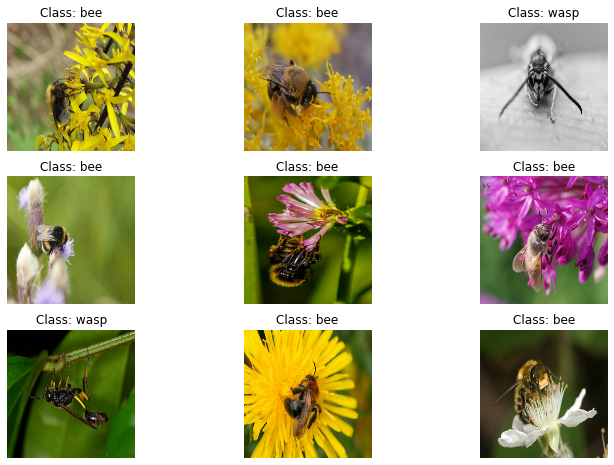

In [ ]:
import matplotlib.pyplot as plt
import PIL
def plot_sample_images(x, y):
    fig = plt.figure(figsize=(12, 8))

    for image, cls, index in zip(x, y, range(9)):
        plt.subplot(3, 3, index + 1)
        plt.imshow((image+1) *255)
        plt.title('Class: ' + str(cls))
        plt.axis('off')
    plt.show()
plot_sample_images(train_data.images[10:20], train_data._cls[10:20])

# Layers function

In [ ]:
def maxPool_layer(x,poolSize):
  # x -> [batch,H,W,Channels]
  return tf.nn.max_pool2d(input=x,ksize=[1,poolSize,poolSize,1],strides=[1,poolSize,poolSize,1],padding="SAME")

def conv_layer(input_x, w, b):
  # input_x -> [batch,H,W,Channels]
  # filter_shape -> [filters H, filters W, Channels In, Channels Out]
  y = tf.nn.conv2d(input=input_x,filters=w,strides=[1,1,1,1],padding='SAME') + b
  y = tf.nn.relu(y)
  return y

def fullyConnected_layer(input_layer,w,b):
    y = tf.add(tf.matmul(input_layer,w), b)
    return y

def get_tfVariable(shape, name):

    return tf.Variable(tf.random.truncated_normal(shape,stddev=0.1), name=name, trainable=True, dtype=tf.float32)

# Model

In [ ]:
class Model():

  def __init__(self):
    
    self.pool_size = 2
    self.dropout = 0.5
    self.nclasses = 2

    self.shapes = [
    [3, 3, 3, 128], 
    [3, 3, 128, 32],
    [32*32*32,512],
    [512, 256],
    [256, self.nclasses]
    ]

    self.weights = []
    for i in range(len(self.shapes)):
      self.weights.append( get_tfVariable(self.shapes[i] , 'weight{}'.format( i ) ) )

    self.bias = []
    for i in range(len(self.shapes)):
      self.bias.append( get_tfVariable([1,self.shapes[i][-1]] , 'bias{}'.format( i ) ) )

  def run(self, x_input):
    
    conv1 = conv_layer(x_input,self.weights[0],self.bias[0]) 
    pool1 = maxPool_layer(conv1,poolSize=self.pool_size)
    
    conv2 = conv_layer(pool1,self.weights[1],self.bias[1]) 
    pool2 = maxPool_layer(conv2,poolSize=self.pool_size)
    
    flat1 = tf.reshape(pool2,[-1,pool2.shape[1]*pool2.shape[2]*pool2.shape[3]])
    
    fully1 = tf.nn.relu(fullyConnected_layer(flat1,self.weights[2],self.bias[2]))
    
    fully1_dropout = tf.nn.dropout(fully1,rate=self.dropout)

    fully2 = tf.nn.relu(fullyConnected_layer(fully1_dropout,self.weights[3],self.bias[3]))
    
    fully2_dropout = tf.nn.dropout(fully2,rate=self.dropout)

    y_pred = fullyConnected_layer(fully2_dropout,self.weights[4],self.bias[4])
    
    #print(conv1.shape,pool1.shape,conv2.shape,pool2.shape,flat1.shape,fully1.shape,y_pred.shape)

    return y_pred

  def trainable_variables(self):

    return self.weights + self.bias

# Train model


In [ ]:
def loss_function(y_pred,y_true):
    return tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)

In [ ]:
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
     

In [ ]:
def show_progress(epoch, train_true, train_pred, valid_true, valid_pred):
    train_acc = accuracy(train_pred, train_true)
    val_acc = accuracy(valid_pred, valid_true)
    train_loss = tf.reduce_mean(loss_function(train_pred, train_true))
    val_loss = tf.reduce_mean(loss_function(valid_pred, valid_true))
    msg = "Training Epoch {0} --- training Accuracy: {1:.4f}, training Losss: {2:.4f} --- validation Accuracy: {3:.4f},  validation Loss: {4:.4f}"
    print(msg.format(epoch, train_acc, train_loss, val_acc, val_loss))

In [ ]:
def train(train, valid, num_iteration):
    model = Model()
    optimizer = tf.optimizers.Adam(learning_rate=0.1)
    train_loss_results = []
    train_accuracy_results = []
    for i in range(num_iteration):

        x_batch, y_true_batch, _, cls_batch = train.next_batch(BATCH_SIZE)
        
        with tf.GradientTape() as tape:
            y_train_pred = model.run(x_batch)
            current_loss = loss_function(y_train_pred, y_true_batch)
            grads = tape.gradient(current_loss, model.trainable_variables())
            optimizer.apply_gradients(zip(grads, model.trainable_variables()))

        if i % 100 == 0: 
            y_val_preds = []
            for val_image in val_data.images:
                y_val_preds.append(model.run(np.expand_dims(val_image, axis=0)))
            y_train_preds = []
            for train_image in train_data.images:
                y_train_preds.append(model.run(np.expand_dims(train_image, axis=0)))    
            y_val_pred = np.vstack(y_val_preds)
            y_train_pred = np.vstack(y_train_preds)

            show_progress(i, train.labels, y_train_pred, valid.labels, y_val_pred)
            

train(train_data, val_data, num_iteration=3000)

Training Epoch 1 --- training Accuracy: 0.5369, training Losss: 9314589.0000 --- validation Accuracy: 0.5386,  validation Loss: 9166836.0000
Training Epoch 101 --- training Accuracy: 0.5371, training Losss: 0.6903 --- validation Accuracy: 0.5386,  validation Loss: 0.6905
Training Epoch 201 --- training Accuracy: 0.5371, training Losss: 0.6920 --- validation Accuracy: 0.5397,  validation Loss: 0.6915
Training Epoch 301 --- training Accuracy: 0.5366, training Losss: 0.6917 --- validation Accuracy: 0.5386,  validation Loss: 0.6900
Training Epoch 401 --- training Accuracy: 0.5355, training Losss: 0.6934 --- validation Accuracy: 0.5365,  validation Loss: 0.6929
Training Epoch 501 --- training Accuracy: 0.5371, training Losss: 0.6905 --- validation Accuracy: 0.5365,  validation Loss: 0.6905
Training Epoch 601 --- training Accuracy: 0.5363, training Losss: 0.6914 --- validation Accuracy: 0.5375,  validation Loss: 0.6949
Training Epoch 701 --- training Accuracy: 0.5369, training Losss: 0.6906 

# Keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 512)       1180160   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 512)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               268435968 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [ ]:
model.fit(train_data.images, train_data.labels, validation_data=(val_data.images, val_data.labels), epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
115/115 [==============================] - 20s 176ms/step - loss: 0.6900 - accuracy: 0.5420 - val_loss: 0.6941 - val_accuracy: 0.5180
Epoch 2/5
115/115 [==============================] - 20s 177ms/step - loss: 0.6900 - accuracy: 0.5420 - val_loss: 0.6937 - val_accuracy: 0.5180
Epoch 3/5
115/115 [==============================] - 20s 177ms/step - loss: 0.6899 - accuracy: 0.5420 - val_loss: 0.6937 - val_accuracy: 0.5180
Epoch 4/5
115/115 [==============================] - 20s 177ms/step - loss: 0.6898 - accuracy: 0.5420 - val_loss: 0.6938 - val_accuracy: 0.5180
Epoch 5/5
115/115 [==============================] - 20s 177ms/step - loss: 0.6901 - accuracy: 0.5420 - val_loss: 0.6946 - val_accuracy: 0.5180


# From Git

In [ ]:
!git init
!git clone https://github.com/AndreyRysistov/BeeVSWasp
!cp -r ./datasets   ./BeeVSWasp/datasets
!pip -q install dotmap
!ls ./BeeVSWasp/datasets

Initialized empty Git repository in /content/.git/
Cloning into 'BeeVSWasp'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22 (delta 0), reused 22 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
data


In [ ]:
!git pull https://github.com/AndreyRysistov/BeeVSWasp

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/AndreyRysistov/BeeVSWasp
 * branch            HEAD       -> FETCH_HEAD
Updating 16d824d..5cdfd99
Fast-forward
 models/conv_model.py | 2 --
 1 file changed, 2 deletions(-)


In [ ]:
%cd BeeVSWasp
!python main.py -c ./configs/exp